# ♻️ Waste Classification Project (Atık Sınıflandırma)
**Final Projesi** - CNN & PyTorch

Bu notebook, Kaggle üzerinden veri setini otomatik çeker, CNN modelini eğitir ve sonuçları grafiklerle gösterir.

In [3]:
# 1. Kütüphaneler ve Ayarlar
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- WINDOWS İÇİN KRİTİK YAMA (DLL Hatasını Önler) ---
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# -----------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import kagglehub

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Kurulum Tamam. Kullanılan Cihaz: {device}")

✅ Kurulum Tamam. Kullanılan Cihaz: cpu


c:\Users\aksoz\anaconda3\envs\atik_proje\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# 2. Veriyi Kaggle'dan Otomatik Çekme
print("⏳ Veri seti Kagglehub üzerinden kontrol ediliyor...")

# Veriyi indir (Otomatik önbelleğe alır, tekrar tekrar indirmez)
path = kagglehub.dataset_download("techsash/waste-classification-data")
print("✅ Veri seti indirildi/bulundu. Yol:", path)

# Klasör Yollarını Otomatik Ayarlama
# İndirilen verinin yapısına göre TRAIN ve TEST klasörlerini buluyoruz
train_dir = os.path.join(path, "DATASET", "TRAIN")
test_dir = os.path.join(path, "DATASET", "TEST")

# Eğer DATASET klasörü yoksa direkt ana dizine bak (Yedek Plan)
if not os.path.exists(train_dir):
    train_dir = os.path.join(path, "TRAIN")
    test_dir = os.path.join(path, "TEST")

print(f"📂 Eğitim Klasörü: {train_dir}")
print(f"📂 Test Klasörü:   {test_dir}")

⏳ Veri seti Kagglehub üzerinden kontrol ediliyor...
✅ Veri seti indirildi/bulundu. Yol: C:\Users\aksoz\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1
📂 Eğitim Klasörü: C:\Users\aksoz\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\TRAIN
📂 Test Klasörü:   C:\Users\aksoz\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\TEST


In [12]:
# 3. Veri Hazırlığı (Preprocessing) - GÜNCELLENMİŞ
# Eğitim seti için: Veri Çoğaltma (Augmentation) ekliyoruz
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),   # %50 ihtimalle resmi yatay çevir (Aynalama)
    transforms.RandomRotation(15),            # Rastgele 15 derece döndür
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Işık ve kontrastla çok az oyna
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test seti için: Sadece standart işlemler (Değişiklik yok)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Klasörleri yüklerken ayrı ayrı transformları veriyoruz
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes
print(f"✅ Gelişmiş Veri Hazırlığı Tamamlandı (Augmentation Aktif). Sınıflar: {class_names}")

✅ Gelişmiş Veri Hazırlığı Tamamlandı (Augmentation Aktif). Sınıflar: ['O', 'R']


In [8]:
# 4. CNN Model Mimarisi
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)
print("🧠 Model Hazır.")

🧠 Model Hazır.


In [15]:
import torch.optim as optim

# --- 1. Modeli ve Ayarları Sıfırla ---
model = CNNModel().to(device) # Modeli sıfırdan başlat
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler: Her 4 epoch'ta bir öğrenme hızını %10'una düşür (Hassas ayar)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# İstatistikleri tutacağımız listeler (Grafik çizmek için gerekli)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_acc = 0.0  # En iyi skoru burada tutacağız
EPOCHS = 12     # Augmentation olduğu için süreyi biraz uzattık

print(f"🚀 Gelişmiş Eğitim Başlıyor ({EPOCHS} Epoch)...")

# --- 2. Eğitim Döngüsü ---
for epoch in range(EPOCHS):
    # --- EĞİTİM MODU (Ders Çalışma) ---
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()           # Önceki artıkları temizle
        outputs = model(inputs)         # Tahmin yap
        loss = criterion(outputs, labels) # Hatayı ölç
        loss.backward()                 # Geri yayılım
        optimizer.step()                # Ağırlıkları güncelle
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Öğrenme hızını güncelle
    scheduler.step()
    
    # --- TEST MODU (Sınav) ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad(): # Testte türev alınmaz
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # --- SONUÇLARI HESAPLA VE KAYDET ---
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    acc_train = 100 * correct_train / total_train
    acc_val = 100 * correct_val / total_val
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(acc_train)
    val_accs.append(acc_val)
    
    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Val Acc: %{acc_val:.2f}")

    # --- EN İYİ MODELİ KAYDET ---
    if acc_val > best_acc:
        best_acc = acc_val
        torch.save(model.state_dict(), "en_iyi_atik_modeli.pth")
        print(f"   💾 YENİ REKOR! Model kaydedildi. (Acc: %{best_acc:.2f})")

print(f"🎉 Eğitim Tamamlandı! En yüksek başarı: %{best_acc:.2f}")

🚀 Gelişmiş Eğitim Başlıyor (12 Epoch)...
Epoch 1/12 -> Train Loss: 0.4409 | Val Acc: %87.31
   💾 YENİ REKOR! Model kaydedildi. (Acc: %87.31)
Epoch 2/12 -> Train Loss: 0.3678 | Val Acc: %87.78
   💾 YENİ REKOR! Model kaydedildi. (Acc: %87.78)
Epoch 3/12 -> Train Loss: 0.3398 | Val Acc: %88.34
   💾 YENİ REKOR! Model kaydedildi. (Acc: %88.34)
Epoch 4/12 -> Train Loss: 0.3241 | Val Acc: %88.46
   💾 YENİ REKOR! Model kaydedildi. (Acc: %88.46)
Epoch 5/12 -> Train Loss: 0.2882 | Val Acc: %90.01
   💾 YENİ REKOR! Model kaydedildi. (Acc: %90.01)
Epoch 6/12 -> Train Loss: 0.2729 | Val Acc: %90.37
   💾 YENİ REKOR! Model kaydedildi. (Acc: %90.37)
Epoch 7/12 -> Train Loss: 0.2672 | Val Acc: %90.41
   💾 YENİ REKOR! Model kaydedildi. (Acc: %90.41)
Epoch 8/12 -> Train Loss: 0.2597 | Val Acc: %90.73
   💾 YENİ REKOR! Model kaydedildi. (Acc: %90.73)
Epoch 9/12 -> Train Loss: 0.2525 | Val Acc: %90.25
Epoch 10/12 -> Train Loss: 0.2499 | Val Acc: %90.25
Epoch 11/12 -> Train Loss: 0.2516 | Val Acc: %90.17
Epoc

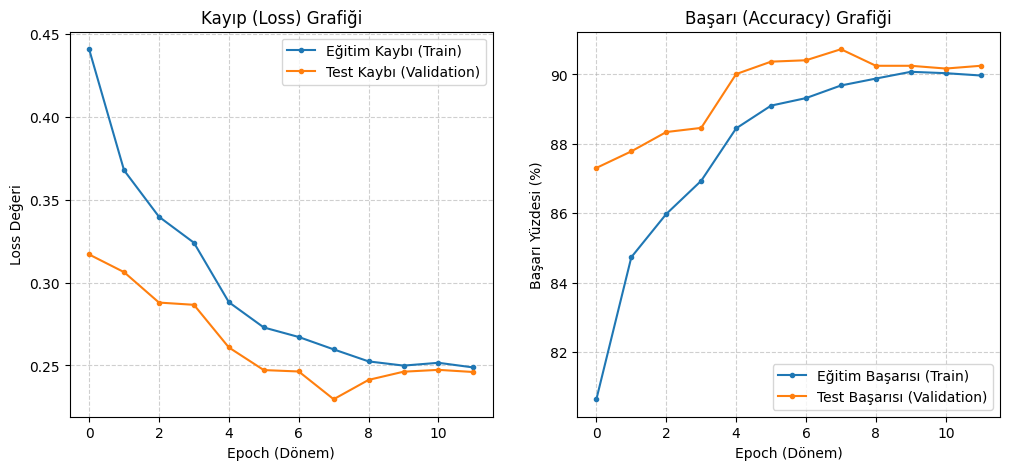

In [18]:
import matplotlib.pyplot as plt
# 6. Grafik Çizme
plt.figure(figsize=(12, 5))#grafiğin boyutu 
# 1. Kayıp (Loss) Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Eğitim Kaybı (Train)', marker='.')
plt.plot(val_losses, label='Test Kaybı (Validation)', marker='.')
plt.title('Kayıp (Loss) Grafiği')
plt.xlabel('Epoch (Dönem)') # Alt tarafa yazı
plt.ylabel('Loss Değeri')   # Yan tarafa yazı
plt.grid(True, linestyle='--', alpha=0.6) # Izgara çizgileri ekle
plt.legend()

# 2. Başarı (Accuracy) Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Eğitim Başarısı (Train)', marker='.')
plt.plot(val_accs, label='Test Başarısı (Validation)', marker='.')
plt.title('Başarı (Accuracy) Grafiği')
plt.xlabel('Epoch (Dönem)')
plt.ylabel('Başarı Yüzdesi (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

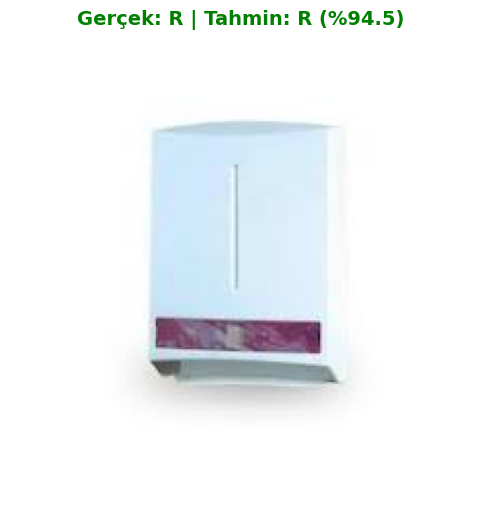

In [22]:
# 7. Modelin test verisi üzerinde denenmesi ve sonuçların görselleştirilmesi
import glob
import random

# Test için dönüşüm işlemleri (Sadece boyutlandırma ve normalize)
predict_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# En iyi model ağırlıklarını yükle
if os.path.exists("en_iyi_atik_modeli.pth"):
    model.load_state_dict(torch.load("en_iyi_atik_modeli.pth"))

model.eval()

def predict_random_image():
    # Test klasöründen rastgele bir görsel seç
    image_list = glob.glob(test_dir + "/*/*.jpg")
    img_path = random.choice(image_list)
    
    # Görseli hazırla
    img = Image.open(img_path)
    img_tensor = predict_transform(img).unsqueeze(0).to(device)
    
    # Tahmin işlemi
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
        
    pred_label = class_names[pred_idx.item()]
    true_label = os.path.basename(os.path.dirname(img_path))
    score = confidence.item() * 100
    
    # Sonucu çizdir
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Gerçek: {true_label} | Tahmin: {pred_label} (%{score:.1f})", 
              color=color, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

predict_random_image()

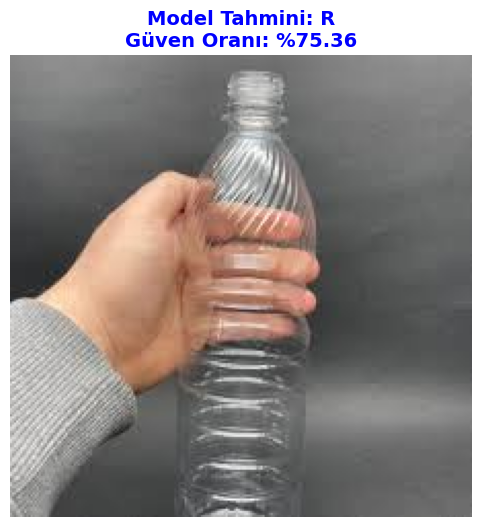

In [23]:
# 8. Harici bir görsel üzerinde modelin test edilmesi (Inference)
import matplotlib.pyplot as plt
from PIL import Image

# --- BURAYA RESMİN YOLUNU YAPIŞTIR ---
# Örnek: r"C:\Users\Adın\Masaüstü\deneme.jpg"
image_path = r"c:\Users\aksoz\OneDrive\Desktop\deneme.jpg" 

def predict_custom_image(path):
    try:
        # Görseli yükle
        img = Image.open(path)
    except FileNotFoundError:
        print(f"❌ Hata: Dosya bulunamadı! Yolu kontrol et:\n{path}")
        return

    # Görseli modelin anlayacağı formata getir
    img_tensor = predict_transform(img).unsqueeze(0).to(device)
    
    # Tahmin yap
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
    
    # Sonucu al
    pred_label = class_names[pred_idx.item()]
    score = confidence.item() * 100
    
    # Ekrana bas
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Model Tahmini: {pred_label}\nGüven Oranı: %{score:.2f}", 
              color='blue', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

# Fonksiyonu çalıştır
predict_custom_image(image_path)